Load Checkpoint Graph
=========
### Test loading a dynamic graph from ".ckpt" file for deployment on website.

In [1]:
import _init_paths
import tensorflow as tf
import glob
from fast_rcnn.config import cfg

# The following lines specify CPU operation for importing the following modules.
cfg.USE_GPU_NMS = False
from fast_rcnn.nms_wrapper import nms

from networks.factory import get_network
from fast_rcnn.test import im_detect

from utils.timer import Timer
import matplotlib.pyplot as plt
import pylab
import numpy as np
import os, sys, cv2
% matplotlib inline

import time

In [2]:
labels = ('__background__',
           'empty_basket', 'full_basket')

In [3]:
path = '/Users/LukeMiller/Git/tensorflow_faster_rcnn/output/BSKT_VGG16/voc_2007_trainval/'
#path = '/root/faster_rcnn/output/BSKT_VGG16/voc_2007_trainval/'

In [4]:
im_dir = '/Users/LukeMiller/Dropbox (Kontingenz)/cartwatch/classification/examples/shopping_for_bratwurst/'
#im_dir = '/root/faster_rcnn/data/VOCdevkit/VOC2007/JPEGImages/'

In [5]:
# Specify confidence and NMS thresholding for bbox accumulation.
CONF_THRESH = 0.4
NMS_THRESH = 0.3

In [15]:
MY_DPI = 2*pylab.gcf().get_dpi()

### Open session and load model

In [7]:
def session_open():
    # Set up graph architecture
    network = get_network("VGGnet_test")
    # Restore graph variables from checkpoint and open session
    saver = tf.train.Saver()
    session = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    saver.restore(session, path + "VGGnet_fast_rcnn_iter_20000.ckpt")    

    print("classifier:setup :: done loading model")

    return session, network

In [8]:
def classify(session, network, image_data):
    scores, boxes = im_detect(session, network, image_data)
    _t = {'im_detect' : Timer(), 'misc' : Timer()}
    
    # Calculate height and width of figure in inches (yes, I know...)
    h_fig = np.shape(image_data)[0]/MY_DPI
    w_fig = np.shape(image_data)[1]/MY_DPI

    fig = plt.figure(frameon=False)
    fig.set_size_inches(w_fig,h_fig)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    # Set aspect to prevent whitespace
    fig.add_axes(ax, aspect='auto')
    ax.imshow(image_data)

    # Perform thresholding and store the results as dictionary
    result = dict()
    for cls_ind, cls in enumerate(labels[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        keep = np.where(dets[:,-1] >= CONF_THRESH)[0]
        dets = dets[keep, :]
        n_dets = np.shape(dets)[0]
        
        # Visualize detections for each class
        if n_dets:
            vis_detections = annotate_image(image_data, cls, dets, ax)
            
        # Update dictionary of classification results
        [result.update({"label": lbl, "value": val, "bbox": box}) for lbl, val, box in 
                   zip([cls]*n_dets, dets[:,-1], dets[:,:4].tolist())]
        
    return image_data, result

In [30]:
def annotate_image(im, class_name, dets, ax):
    if 'empty' in class_name:
        bbox_colour = 'green'
    elif 'full' in class_name:
        bbox_colour = 'red'
    for i in xrange(dets.shape[0]):
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=True,
                          edgecolor=bbox_colour, linewidth=3.5, 
                          facecolor=bbox_colour, alpha=0.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=18, color='white')
    plt.draw()

In [18]:
def read_and_convert_image(session, image_name):
    content = tf.gfile.FastGFile(image_name, 'rb').read()

    decoder = None
    name = image_name.lower()

    if name.endswith('jpg') or name.endswith('jpeg'):
        decoder = tf.image.decode_jpeg(content, channels=3)
    elif name.endswith('png'):
        decoder = tf.image.decode_png(content, channels=3)
    elif name.endswith('gif'):
        decoder = tf.image.decode_gif(content)
    else:
        raise(ValueError("Unsupported file type"))

    return decoder.eval(session=session)

In [19]:
def save_image(image_data,image_name):
    image_name_bbox = os.path.splitext(image_name)[0]+"_bbox"+os.path.splitext(image_name)[1]
    plt.savefig(image_name_bbox,dpi=MY_DPI)
    return image_data

In [43]:
def run(session, network, image_name):
    _t = {'im_convert' : Timer(), 'im_detect' : Timer(), 'im_save' : Timer()}
    _t['im_convert'].tic()
    converted_image = read_and_convert_image(session, image_name)
    _t['im_convert'].toc()
    _t['im_detect'].tic()
    image_data, result = classify(session, network, converted_image)
    _t['im_detect'].toc()
    _t['im_save'].tic()
    save_image(image_data,image_name)
    _t['im_save'].toc()
    print 'time for im_convert: {:.3f}s, im_detect: {:.3f}s, im_save: {:.3f}s' \
                    .format(_t['im_convert'].average_time,_t['im_detect'].average_time,
                            _t['im_save'].average_time)
    return image_data, result

In [13]:
session, network = session_open()

Tensor("Placeholder:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("conv5_3/conv5_3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_conv/3x3/rpn_conv/3x3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_cls_score/rpn_cls_score:0", shape=(?, ?, ?, 18), dtype=float32)
Tensor("rpn_cls_prob:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("rpn_cls_prob_reshape:0", shape=(?, ?, ?, 18), dtype=float32)
Tensor("rpn_bbox_pred/rpn_bbox_pred:0", shape=(?, ?, ?, 36), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 3), dtype=float32)
Tensor("conv5_3/conv5_3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rois:0", shape=(?, 5), dtype=float32)
[<tf.Tensor 'conv5_3/conv5_3:0' shape=(?, ?, ?, 512) dtype=float32>, <tf.Tensor 'rois:0' shape=(?, 5) dtype=float32>]
Tensor("fc7/fc7:0", shape=(?, 4096), dtype=float32)
classifier:setup :: done loading model


Classifying /Users/LukeMiller/Dropbox (Kontingenz)/cartwatch/classification/examples/shopping_for_bratwurst/IMG_0265.jpg
time for im_convert: 0.370s, im_detect: 6.673s, im_save: 1.210s


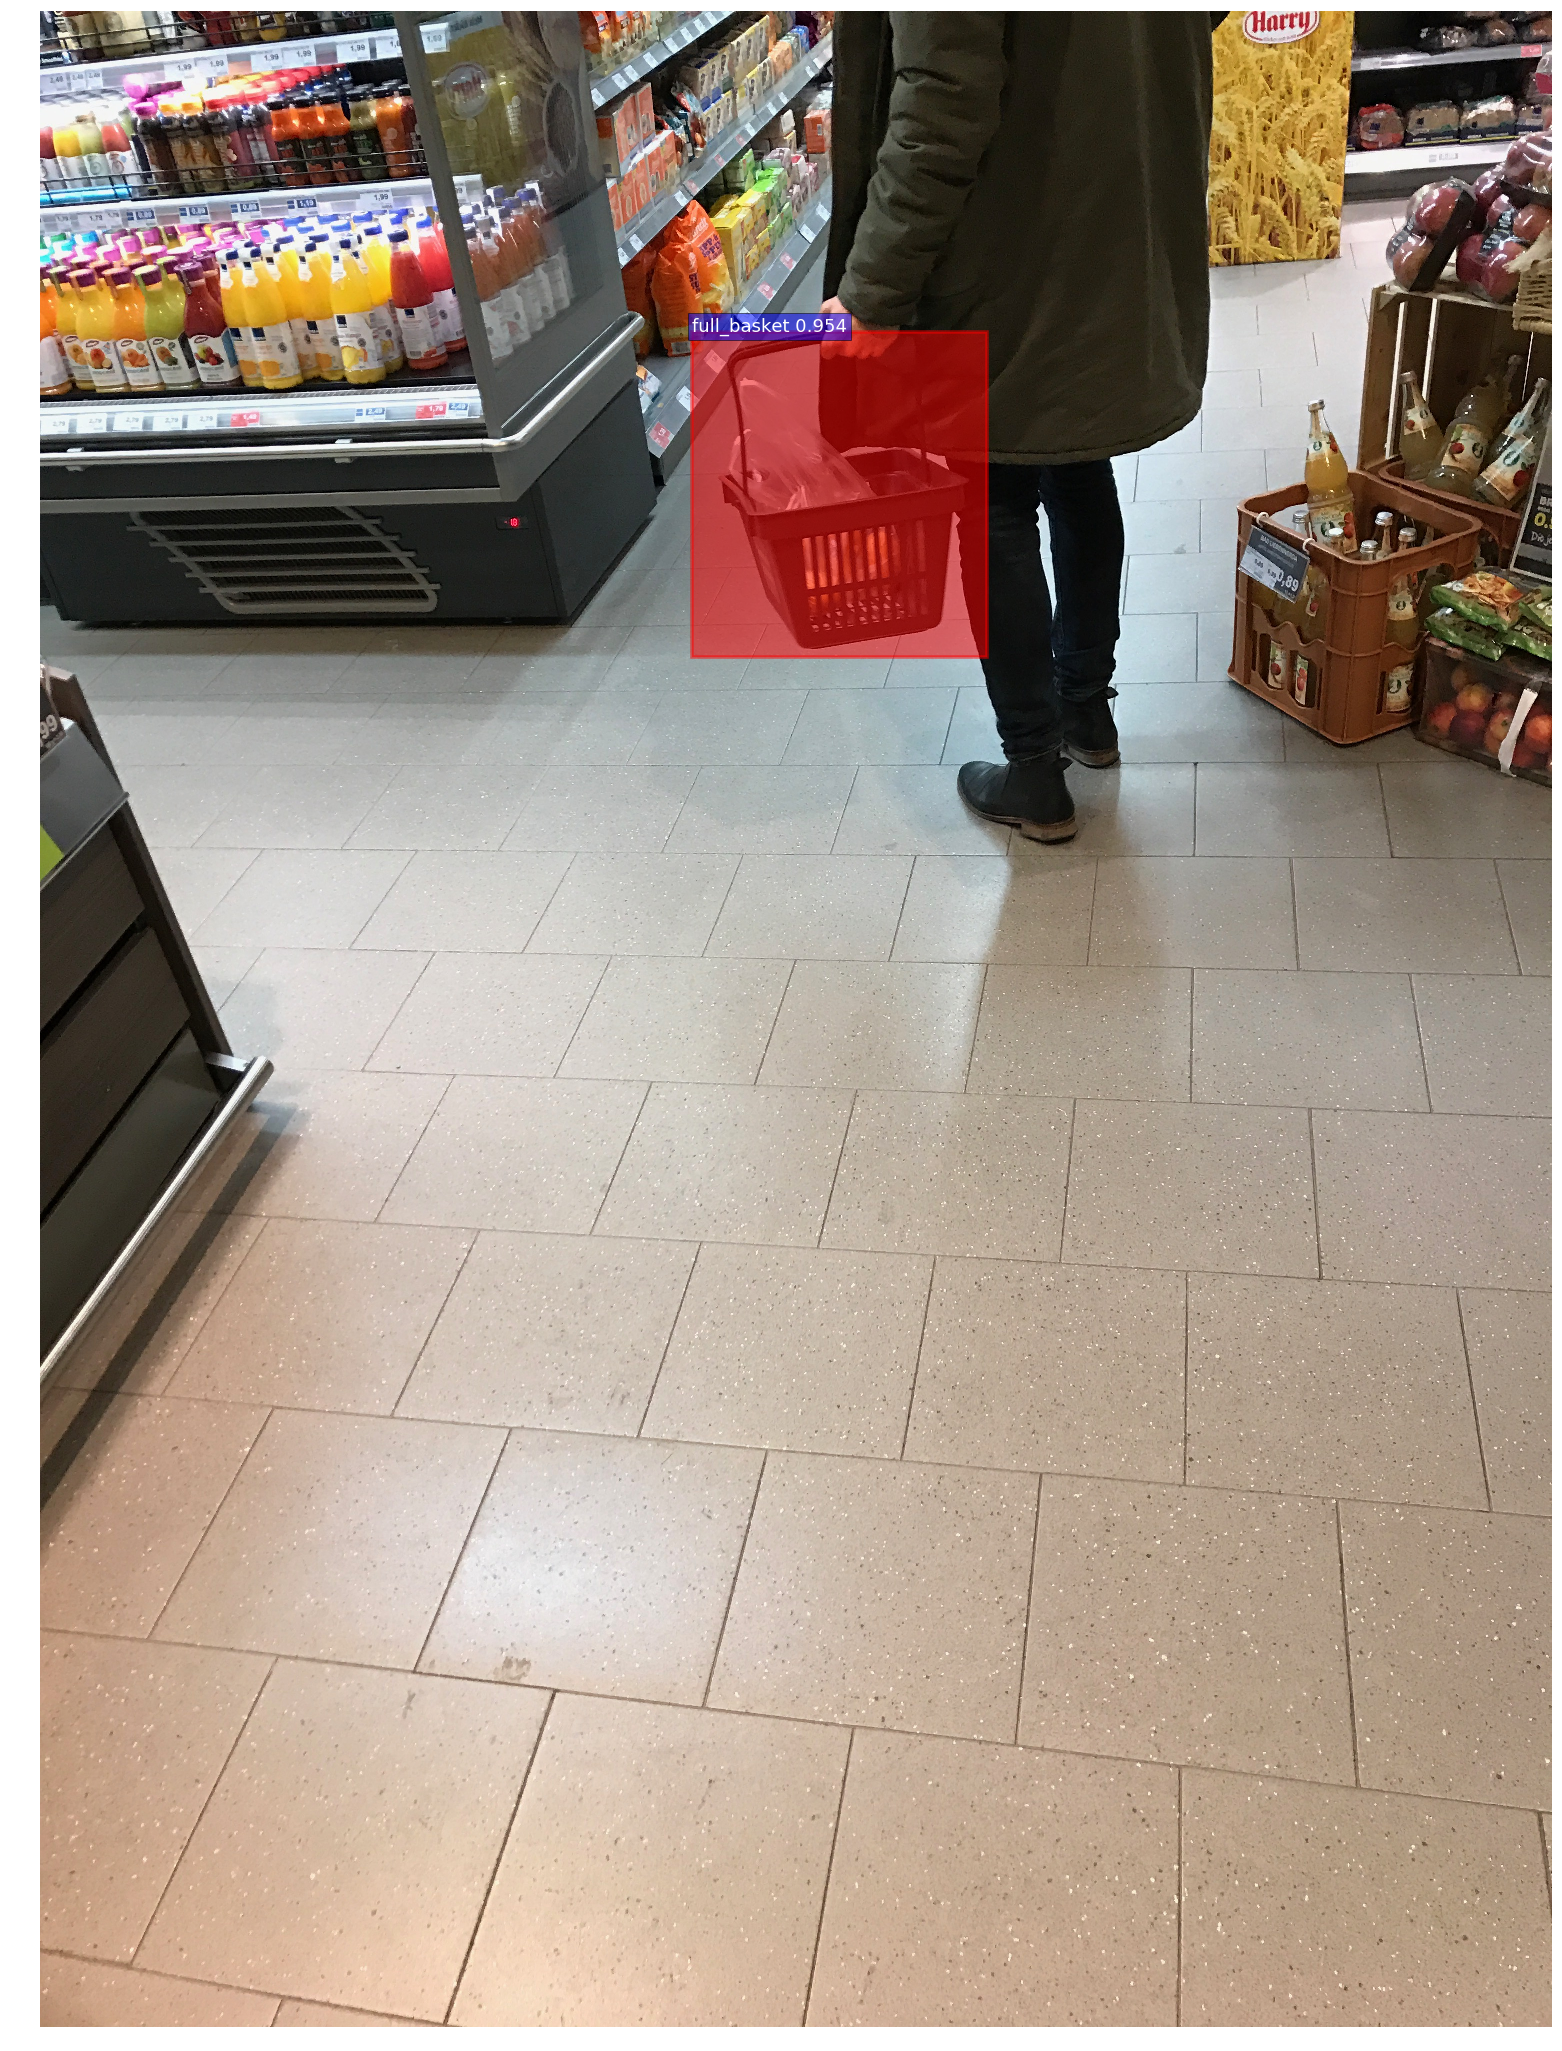

In [44]:
for image_name in glob.glob(im_dir+'/*.jpg')[0:1]:
    print("Classifying %s")%image_name
    image, classification = run(session, network, image_name)

### Define function to capture image from webcam
30 frames are taken to allow the camera to adjust to the lighting conditions.

In [8]:
def get_image(feed,ramp_frames=30):
    for i in xrange(ramp_frames):
        temp = feed.read()[1]
    # Capture image after adjusting to lighting conditions
    return feed.read()[1]

### Perform inference on image captured from webcam

Detection took 5.436s for 237 object proposals


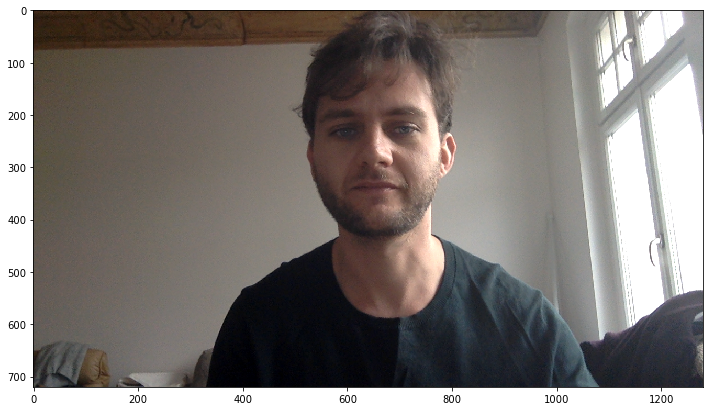

In [11]:
# Unless more than one webcam is plugged in, the default is '0'
feed = cv2.VideoCapture(0)
# Capture frame from webcam
current_frame = get_image(feed)
# Release after capture
feed.release()
# Perform inference
demo(sess, net, current_frame)
plt.show()